In [24]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
s = 2
r = 0.03
rho = 0.05
z1 = .1
z2 = .2
z = np.array([z1,z2])
la1 = 0.02
la2 = 0.03
la = np.array([la1,la2])
I=500
amin=-0.02
amax=2
a=np.linspace(amin, amax, I)
da=(amax-amin)/(I-1)
aa=np.array([a,a]).T
zz=np.ones((I,1))*z


"""Initial guess"""
v01 = (z[0]+r*a)**(1-s)/(1-s)/rho
v02 = (z[1]+r*a)**(1-s)/(1-s)/rho
v0=np.array([v01,v02]).T
v=copy.deepcopy(v0)

maxit= 100
Delta = 1000
crit = 10**(-6)

dVf = np.zeros((I,2))
dVb = np.zeros((I,2))
c=np.zeros((I,2))

Aswitch1 = scipy.sparse.hstack([-scipy.sparse.eye(I)*la1, scipy.sparse.eye(I)*la1])
Aswitch2 = scipy.sparse.hstack([scipy.sparse.eye(I)*la2, -scipy.sparse.eye(I)*la2])
Aswitch = scipy.sparse.vstack([Aswitch1, Aswitch2])

dist=np.zeros(maxit)

In [25]:
for n in range(maxit):
    V = copy.deepcopy(v)
    ## forward difference method eq.(8)
    dVf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVf[I-1,:] = 1 ## never be used, but set 1 make sure there is no exception
    ## backward difference method eq.(8)
    dVb[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
    dVb[0,:] = (z+r*amin)**(-s)
    ## consumption and savings with forward difference     u=x^(1-s)/1-s  => (u')^-1: x^(-1/s) 
    cf = dVf**(-1/s)
    sf = zz + r*aa - cf
    ## consumption and savings with backward difference
    cb = dVb**(-1/s)
    sb = zz + r*aa - cb
    ## consumption and derivative of value function at steady state
    c0 = zz + r*aa
    dV0 = c0**(-s)
    ## the indicator of upwind scheme 
    If = np.where(sf>0, 1, 0)
    Ib = np.where(sb<0, 1, 0)
    I0 = (1-If-Ib)     ## sijF<0<sijB
    dV_Upwind = dVf*If + dVb*Ib + dV0*I0
    ## compute c and u
    c = dV_Upwind**(-1/s)
    u = c**(1-s)/(1-s)
    ## CONSTRUCT MATRIX
    X = -np.minimum(sb,0)/da
    Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
    Z = np.maximum(sf,0)/da
    A1 = scipy.sparse.spdiags(Y[:,0],0,I,I)+scipy.sparse.spdiags(X[1:,0],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,0]]),1,I,I)
    A2 = scipy.sparse.spdiags(Y[:,1],0,I,I)+scipy.sparse.spdiags(X[1:,1],-1,I,I)+scipy.sparse.spdiags(np.concatenate([np.array([0]),Z[:,1]]),1,I,I)
    A = scipy.sparse.vstack([scipy.sparse.hstack([A1, scipy.sparse.csc_matrix((I,I))]), scipy.sparse.hstack([scipy.sparse.csc_matrix((I,I)), A2])]) + Aswitch
    B = (rho + 1/Delta)*scipy.sparse.eye(2*I) - A
    u_stacked = np.vstack((u[:,0].reshape((I,1)), u[:,1].reshape((I,1))))
    V_stacked = np.vstack([V[:,0].reshape((I,1)), V[:,1].reshape((I,1))])
    b = u_stacked + V_stacked/Delta
    V_stacked = scipy.sparse.linalg.spsolve(B, b)
    V[:,0] = np.squeeze(V_stacked[0:I])
    V[:,1] = np.squeeze(V_stacked[I:])
    Vchange = V - v
    v=copy.deepcopy(V)
    dist[n] = np.max(np.abs(Vchange))
    if dist[n] < crit:
        print("Value function is converged. Iteration is:", n)
        break

Value function is converged. Iteration is: 10


In [32]:
adot = zz + r*aa - c

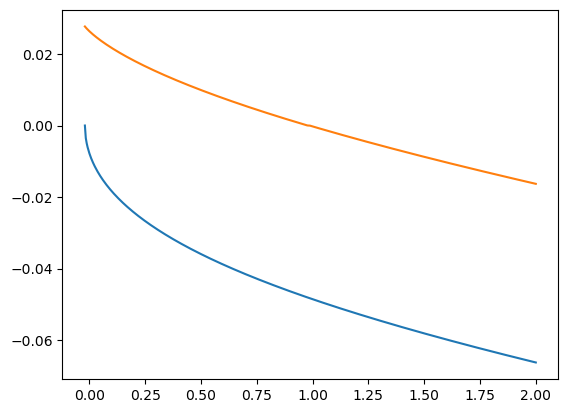

In [33]:
import matplotlib.pyplot as plt
plt.plot(a, adot)

In [34]:
adot[-1,0]

-0.06625432384482882

In [35]:
adot[-1,1]

-0.016303274410193358

In [36]:
adot

array([[ 0.00000000e+00,  2.76938103e-02],
       [-3.51140384e-03,  2.73942449e-02],
       [-4.96268040e-03,  2.71159883e-02],
       [-6.06791261e-03,  2.68523300e-02],
       [-6.99331852e-03,  2.65999266e-02],
       [-7.80361442e-03,  2.63567363e-02],
       [-8.53208446e-03,  2.61213620e-02],
       [-9.19853595e-03,  2.58927807e-02],
       [-9.81588977e-03,  2.56702083e-02],
       [-1.03931282e-02,  2.54530224e-02],
       [-1.09367951e-02,  2.52407165e-02],
       [-1.14518324e-02,  2.50328697e-02],
       [-1.19420809e-02,  2.48291265e-02],
       [-1.24105955e-02,  2.46291824e-02],
       [-1.28598532e-02,  2.44327734e-02],
       [-1.32918958e-02,  2.42396687e-02],
       [-1.37084296e-02,  2.40496644e-02],
       [-1.41108981e-02,  2.38625792e-02],
       [-1.45005348e-02,  2.36782509e-02],
       [-1.48784044e-02,  2.34965333e-02],
       [-1.52454327e-02,  2.33172940e-02],
       [-1.56024311e-02,  2.31404129e-02],
       [-1.59501155e-02,  2.29657800e-02],
       [-1.